https://www.allesfitter.com/allesclass/retriving-data-and-models

## stellar parameters

In [3]:
import pandas as pd
import numpy as np

samples = pd.read_hdf('../isochrones/jhkp/mist_starmodel_single.h5', key='derived_samples')

rstar = samples['radius'].median() 
urstar = samples['radius'].std() 
mstar = samples['mass'].median() 
umstar = samples['mass'].std() 

teff = samples['Teff'].median()
uteff = samples['Teff'].std()
logg = samples['logg'].median()
ulogg = samples['logg'].std()
feh = samples['feh'].median()
ufeh = samples['feh'].std()

for p in ['radius', 'mass', 'Teff', 'logg', 'feh', 'AV']:
    x = samples[p].median() 
    y = samples[p].std() 
    print(f'{p}={x:.2f}+/-{y:.2f}')

radius=0.78+/-0.01
mass=0.84+/-0.03
Teff=5241.18+/-43.51
logg=4.58+/-0.02
feh=-0.08+/-0.07
AV=0.21+/-0.14


## retrieving data and models

### tess (s2 & 3 only)

In [8]:
import os
import pickle
import gzip
from allesfitter import config as config_tess

datadir = '../allesfitter/transit/tess'
config_tess.init(datadir)
f = gzip.GzipFile(os.path.join(config_tess.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_tess = pickle.load(f)
f.close()

results_tess.keys(), len(results_tess)

Filling the Basement


allesfitter version
---------------------
v1.2.10
OrderedDict([('user-given:', ''),
             ('companions_phot', ['b']),
             ('companions_rv', []),
             ('inst_phot', ['tess']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '50'),
             ('fast_fit', 'True'),
             ('fast_fit_width', '0.3333333333333333'),
             ('secondary_eclipse', 'False'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch', ['tess']),
             ('mcmc_nwalkers', '100'),
             ('mcmc_total_steps', '2000'),
             ('mcmc_burn_steps', '1000'),
             ('mcmc_thin_by', '1'),
             ('ns_modus', 'dynamic'),
             ('ns_nlive', '500'),
             ('ns_bound', 'single'),
             ('ns_sample', 'rwalk'),
             ('ns_tol', '0.01'),
             ('host_ld_law_tess', 'quad'),
             ('baseline_flux_te

FileNotFoundError: [Errno 2] No such file or directory: '../allesfitter/transitv2/with_rhostar_prior/tess2/results/save_ns.pickle.gz'

In [4]:
instruments = config_tess.BASEMENT.fulldata.keys()
instruments

dict_keys(['tess'])

In [5]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess)
posterior_samples_tess.shape

(25979, 10)

In [6]:
posterior_params_tess = nested_sampling_output.draw_ns_posterior_samples(results_tess, as_type='dic') # all weighted posterior_samples
posterior_params_median_tess, posterior_params_ll_tess, posterior_params_ul_tess = general_output.get_params_from_samples(posterior_samples_tess)

In [7]:
import allesfitter
import numpy as np

#::: your settings
inst = 'tess' 
key = 'flux' 

#::: initialize the allesclass
af_tess = allesfitter.allesclass(datadir)

df = {}
df[inst] = {}

#::: load the data (and the correct error bars)
df[inst]['time'] = af_tess.data[inst]['time']
df[inst]['flux'] = af_tess.data[inst][key]
df[inst]['flux_err'] = af_tess.data[inst]['err_scales_'+key] * af_tess.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model


df[inst]['baseline'] = af_tess.get_posterior_median_baseline(inst, key)
df[inst]['model'] = af_tess.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df[inst]['detrended_flux'] = df[inst]['flux']-df[inst]['baseline']
df[inst]['residuals'] = df[inst]['flux']-(df[inst]['model']+df[inst]['baseline'])

#::: save everything to a file for your collaborators
# X = np.column_stack((time, flux, flux_err, detrended_flux, model, residuals))
# np.savetxt('my_final_file.csv', X, delimiter=',')

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458379.413209
	shifted by 6 periods


Text(0.5, 0.98, '$TESS$ (sectors 2,3)')

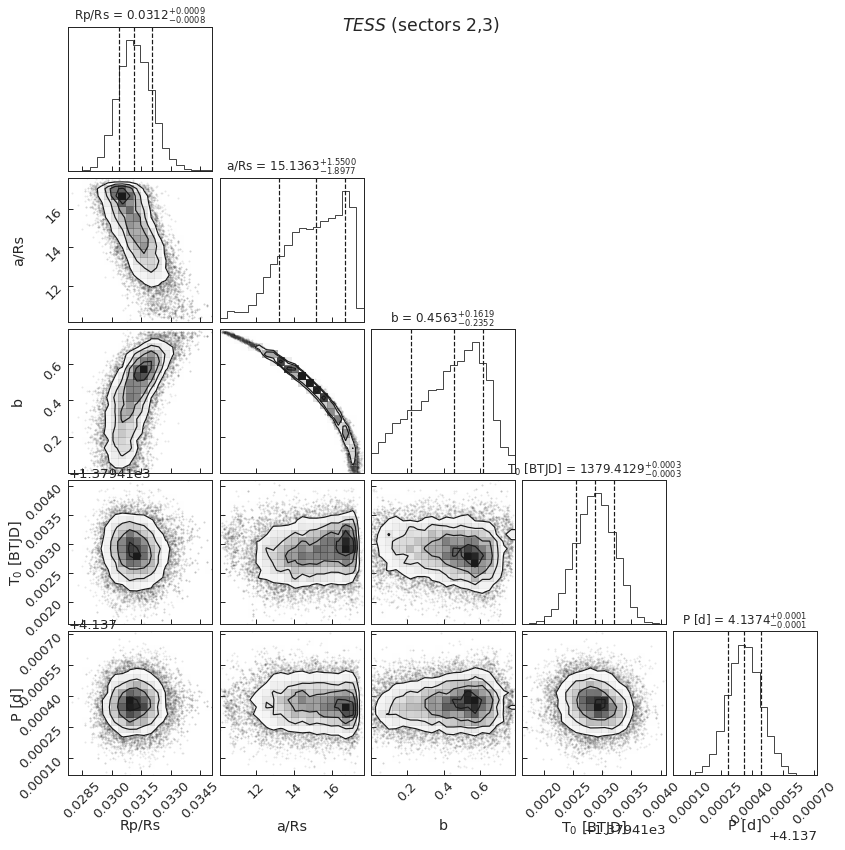

In [8]:
import corner
import pandas as pd

df_samples_tess = pd.DataFrame.from_dict(posterior_params_tess)
df_samples_tess.head()
df_samples_tess['b_epoch'] = df_samples_tess['b_epoch']-2457000

df_samples_tess['aRs'] = 1/df_samples_tess['b_rsuma']
df_samples_tess['inc'] = np.rad2deg(np.arccos(df_samples_tess['b_cosi']))
df_samples_tess['imp_par'] = df_samples_tess['b_cosi']*df_samples_tess['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig1 = corner.corner(df_samples_tess[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig1.suptitle('$TESS$ (sectors 2,3)')

In [9]:
df[inst]['posterior_samples'] = df_samples_tess

### tess (29, 30 only)

In [10]:
import flammkuchen as fk

d = fk.load("../allesfitter/transit/tess3/tess3_results.h5")
df['tess3'] = d['tess']

In [11]:
d['tess'].keys()

dict_keys(['baseline', 'detrended_flux', 'flux', 'flux_err', 'model', 'posterior_samples', 'residuals', 'time'])

### tess (s2, 3, 29, 30)

In [12]:
from allesfitter import config as config_tess2

datadir = '../allesfitter/transit/tess2'
config_tess2.init(datadir)
f = gzip.GzipFile(os.path.join(config_tess2.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_tess2 = pickle.load(f)
f.close()

results_tess2.keys(), len(results_tess2)

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458747.644195
	shifted by 95 periods


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [13]:
results_tess2['samples'].shape

(31638, 10)

In [14]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_tess2 = nested_sampling_output.draw_ns_posterior_samples(results_tess2)
posterior_samples_tess2.shape

(31638, 10)

In [15]:
posterior_params_tess2 = nested_sampling_output.draw_ns_posterior_samples(results_tess2, as_type='dic') # all weighted posterior_samples
posterior_params_median_tess2, posterior_params_ll_tess2, posterior_params_ul_tess2 = general_output.get_params_from_samples(posterior_samples_tess2)

In [16]:
import allesfitter
import numpy as np

#::: your settings
inst = 'tess' 
inst2 = 'tess2' 
key = 'flux' 

#::: initialize the allesclass
af_tess2 = allesfitter.allesclass(datadir)

df[inst2] = {}


#::: load the data (and the correct error bars)
df[inst2]['time'] = af_tess2.data[inst]['time']
df[inst2]['flux'] = af_tess2.data[inst][key]
df[inst2]['flux_err'] = af_tess2.data[inst]['err_scales_'+key] * af_tess2.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model


df[inst2]['baseline'] = af_tess2.get_posterior_median_baseline(inst, key)
df[inst2]['model'] = af_tess2.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df[inst2]['detrended_flux'] = df[inst2]['flux']-df[inst2]['baseline']
df[inst2]['residuals'] = df[inst2]['flux']-(df[inst2]['model']+df[inst2]['baseline'])

#::: save everything to a file for your collaborators
# X = np.column_stack((time, flux, flux_err, detrended_flux, model, residuals))
# np.savetxt('my_final_file.csv', X, delimiter=',')

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458747.644195
	shifted by 95 periods


Text(0.5, 0.98, '$TESS$ (sectors 2,3,29,30)')

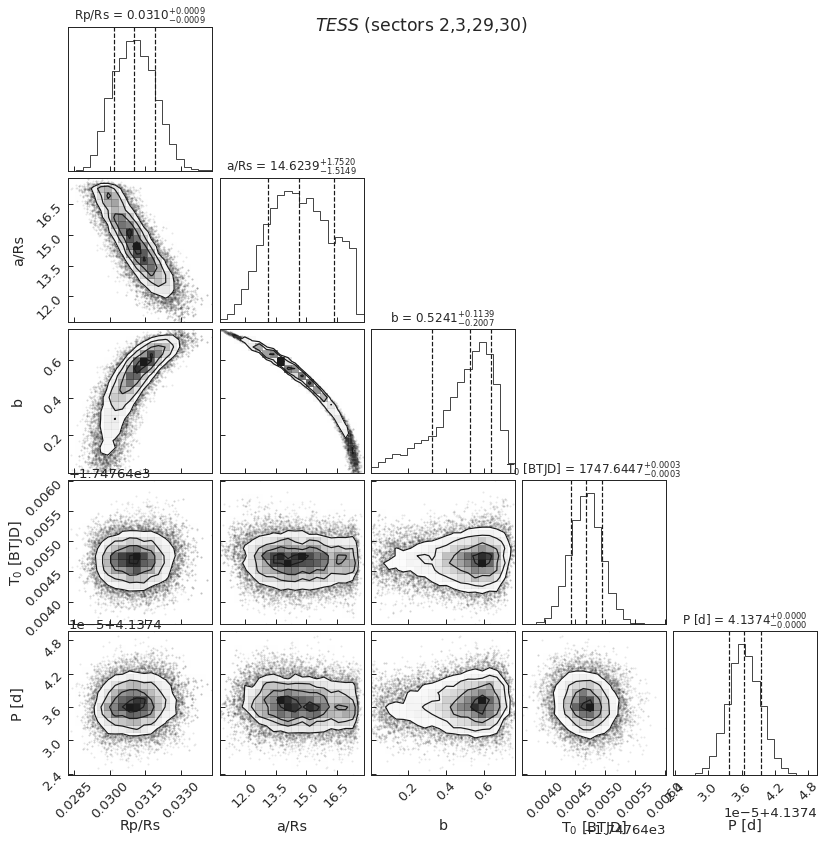

In [17]:
import corner
import pandas as pd

df_samples_tess2 = pd.DataFrame.from_dict(posterior_params_tess2)
df_samples_tess2.head()
df_samples_tess2['b_epoch'] = df_samples_tess2['b_epoch']-2457000

df_samples_tess2['aRs'] = 1/df_samples_tess2['b_rsuma']
df_samples_tess2['inc'] = np.rad2deg(np.arccos(df_samples_tess2['b_cosi']))
df_samples_tess2['imp_par'] = df_samples_tess2['b_cosi']*df_samples_tess2['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig1b = corner.corner(df_samples_tess2[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig1b.suptitle('$TESS$ (sectors 2,3,29,30)')

In [18]:
df[inst2]['posterior_samples'] = df_samples_tess2

### spitzer

In [19]:
import os
import pickle
import gzip
from allesfitter import config as config_spitzer

datadir = '../allesfitter/transit/spitzer/'
config_spitzer.init(datadir)
f = gzip.GzipFile(os.path.join(config_spitzer.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_spitzer = pickle.load(f)
f.close()

results_spitzer.keys(), len(results_spitzer)

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458602.854085
	shifted by 60 periods


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [20]:
instruments = config_spitzer.BASEMENT.fulldata.keys()
instruments

dict_keys(['spitzer'])

In [21]:
results_spitzer['samples'].shape

(21939, 10)

In [22]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_spitzer = nested_sampling_output.draw_ns_posterior_samples(results_spitzer)
posterior_samples_spitzer.shape

(21939, 10)

In [23]:
config_spitzer.BASEMENT.fitkeys, len(config_spitzer.BASEMENT.fitkeys) 

(array(['b_rr', 'b_rsuma', 'b_cosi', 'b_epoch', 'b_period',
        'host_ldc_q1_spitzer', 'host_ldc_q2_spitzer',
        'ln_err_flux_spitzer', 'baseline_gp_matern32_lnsigma_flux_spitzer',
        'baseline_gp_matern32_lnrho_flux_spitzer'], dtype='<U41'),
 10)

In [24]:
posterior_params_spitzer = nested_sampling_output.draw_ns_posterior_samples(results_spitzer, as_type='dic') # all weighted posterior_samples
posterior_params_median_spitzer, posterior_params_ll_spitzer, posterior_params_ul_spitzer = general_output.get_params_from_samples(posterior_samples_spitzer)

In [25]:
import allesfitter
import numpy as np

#::: your settings
inst = 'spitzer' 
key = 'flux' 

#::: initialize the allesclass
af_spitzer = allesfitter.allesclass(datadir)

df[inst] = {}

#::: load the data (and the correct error bars)
df[inst]['time'] = af_spitzer.data[inst]['time']
df[inst]['flux'] = af_spitzer.data[inst][key]
df[inst]['flux_err'] = af_spitzer.data[inst]['err_scales_'+key] * af_spitzer.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model
df[inst]['baseline'] = af_spitzer.get_posterior_median_baseline(inst, key)
df[inst]['model'] = af_spitzer.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df[inst]['detrended_flux'] = df[inst]['flux']-df[inst]['baseline']
df[inst]['residuals'] = df[inst]['flux']-(df[inst]['model']+df[inst]['baseline'])

#::: save everything to a file for your collaborators
# X = np.column_stack((time, flux, flux_err, detrended_flux, model, residuals))
# np.savetxt('my_final_file.csv', X, delimiter=',')

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458602.854085
	shifted by 60 periods


Text(0.5, 0.98, '$Spitzer$')

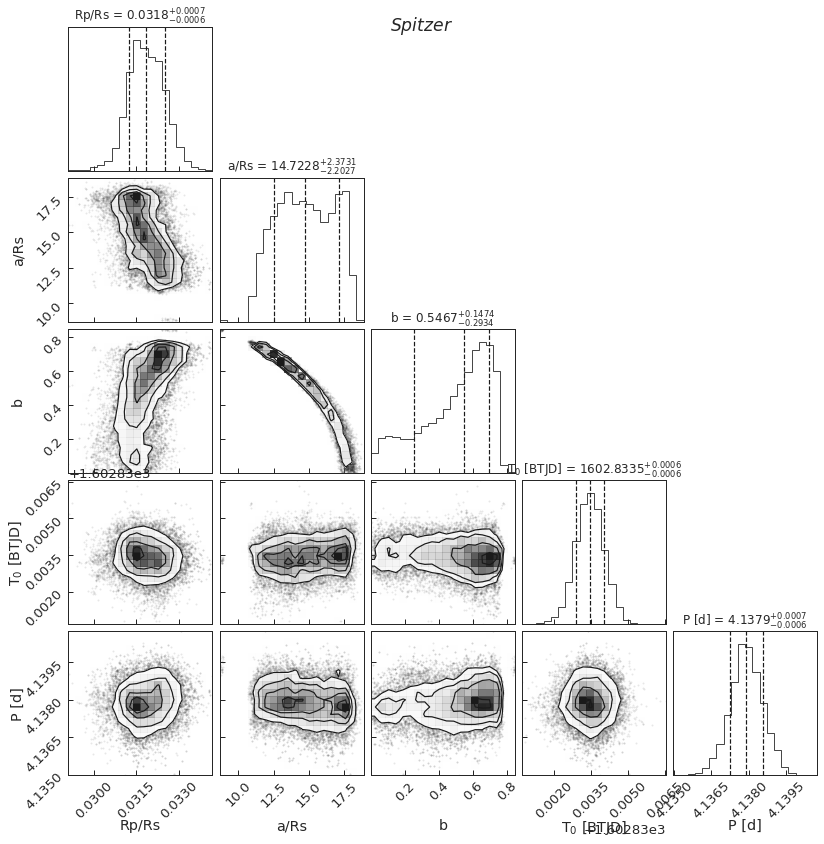

In [26]:
import corner
import pandas as pd

df_samples_spitzer = pd.DataFrame.from_dict(posterior_params_spitzer)
df_samples_spitzer.head()
df_samples_spitzer['b_epoch'] = df_samples_spitzer['b_epoch']-2457000

df_samples_spitzer['aRs'] = 1/df_samples_spitzer['b_rsuma']
df_samples_spitzer['inc'] = np.rad2deg(np.arccos(df_samples_spitzer['b_cosi']))
df_samples_spitzer['imp_par'] = df_samples_spitzer['b_cosi']*df_samples_spitzer['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig = corner.corner(df_samples_spitzer[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f'
                      )
fig.suptitle('$Spitzer$')

In [27]:
df[inst]['posterior_samples'] = df_samples_spitzer

### tess+spitzer

In [28]:
import os
import pickle
import gzip
from allesfitter import config as config_joint

datadir = '../allesfitter/transit/tess_spitzer/gp/'
config_joint.init(datadir)
f = gzip.GzipFile(os.path.join(config_joint.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_joint = pickle.load(f)
f.close()

results_joint.keys(), len(results_joint)

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458478.720265
	shifted by 30 periods


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [29]:
instruments = config_joint.BASEMENT.fulldata.keys()
instruments

dict_keys(['tess', 'spitzer'])

In [30]:
results_joint['samples'].shape

(28458, 15)

In [31]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_joint = nested_sampling_output.draw_ns_posterior_samples(results_joint)
posterior_samples_joint.shape

(28458, 15)

In [32]:
config_joint.BASEMENT.fitkeys, len(config_joint.BASEMENT.fitkeys) 

(array(['b_rr', 'b_rsuma', 'b_cosi', 'b_epoch', 'b_period',
        'host_ldc_q1_tess', 'host_ldc_q2_tess', 'host_ldc_q1_spitzer',
        'host_ldc_q2_spitzer', 'ln_err_flux_tess', 'ln_err_flux_spitzer',
        'baseline_gp_matern32_lnsigma_flux_tess',
        'baseline_gp_matern32_lnrho_flux_tess',
        'baseline_gp_matern32_lnsigma_flux_spitzer',
        'baseline_gp_matern32_lnrho_flux_spitzer'], dtype='<U41'),
 15)

In [33]:
posterior_params_joint = nested_sampling_output.draw_ns_posterior_samples(results_joint, as_type='dic') # all weighted posterior_samples
posterior_params_median, posterior_params_ll, posterior_params_ul = general_output.get_params_from_samples(posterior_samples_joint)

In [34]:
import allesfitter
import numpy as np

#::: your settings
inst = 'spitzer' #or 'tess'
key = 'flux' 

#::: initialize the allesclass
af_joint = allesfitter.allesclass(datadir)

#::: load the data (and the correct error bars)
time = af_joint.data[inst]['time']
flux = af_joint.data[inst][key]
flux_err = af_joint.data[inst]['err_scales_'+key] * af_joint.posterior_params_median['err_'+key+'_'+inst]

df['joint']  = {}
#::: load the median baseline and median lightcurve model
df['joint'][f'baseline_{inst}'] = af_joint.get_posterior_median_baseline(inst, key)
df['joint'][f'model_{inst}'] = af_joint.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df['joint'][f'detrended_flux_{inst}'] = flux-df['joint'][f'baseline_{inst}']
df['joint'][f'residuals_{inst}'] = flux-(df['joint'][f'model_{inst}']+df['joint'][f'baseline_{inst}'])

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458478.720265
	shifted by 30 periods


In [35]:
inst = 'tess'

#::: load the data (and the correct error bars)
time = af_joint.data[inst]['time']
flux = af_joint.data[inst][key]
flux_err = af_joint.data[inst]['err_scales_'+key] * af_joint.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model
df['joint'][f'baseline_{inst}'] = af_joint.get_posterior_median_baseline(inst, key)
df['joint'][f'model_{inst}'] = af_joint.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df['joint'][f'detrended_flux_{inst}'] = flux-df['joint'][f'baseline_{inst}']
df['joint'][f'residuals_{inst}'] = flux-(df['joint'][f'model_{inst}']+df['joint'][f'baseline_{inst}'])

Text(0.5, 0.98, '$Spitzer$ + $TESS$ (sectors 2,3)')

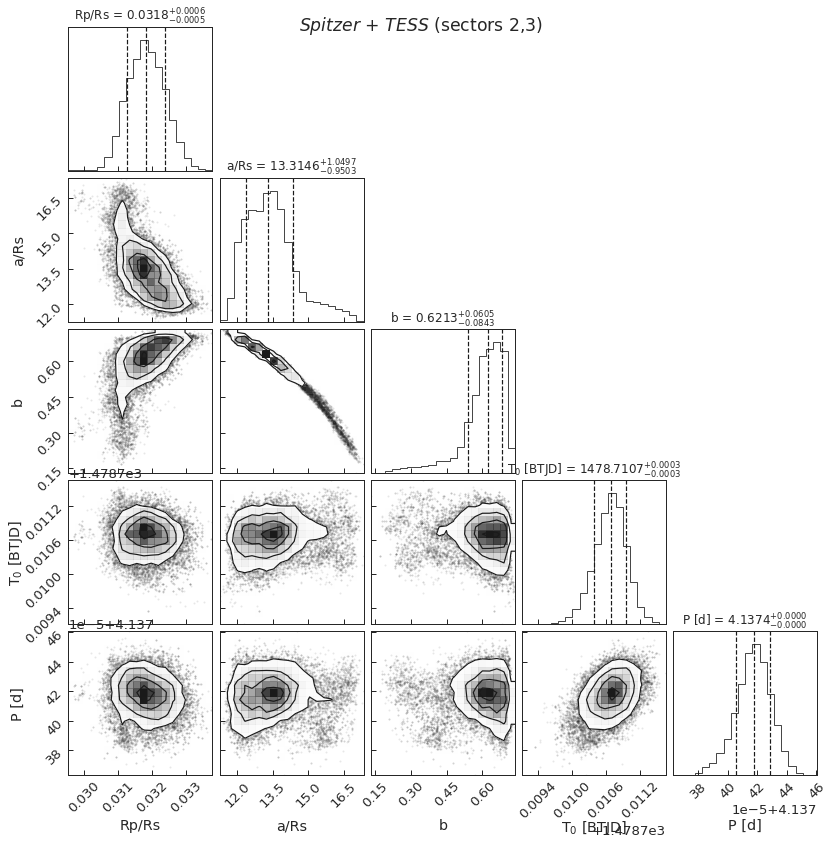

In [36]:
import corner
import pandas as pd

df_samples_joint = pd.DataFrame.from_dict(posterior_params_joint)
df_samples_joint.head()
df_samples_joint['b_epoch'] = df_samples_joint['b_epoch']-2457000

df_samples_joint['aRs'] = 1/df_samples_joint['b_rsuma']
df_samples_joint['inc'] = np.rad2deg(np.arccos(df_samples_joint['b_cosi']))
df_samples_joint['imp_par'] = df_samples_joint['b_cosi']*df_samples_joint['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig2 = corner.corner(df_samples_joint[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig2.suptitle('$Spitzer$ + $TESS$ (sectors 2,3)')

In [37]:
df['joint']['posterior_samples'] = df_samples_joint

In [38]:
instruments = config_joint.BASEMENT.fulldata.keys()
instruments

dict_keys(['tess', 'spitzer'])

### tess+spitzer 2

In joint fitting the tess and spitzer light curves, we tested 2 baseline models consisting of gp and sample offset.

* GP Matern 3/2 for TESS & Spitzer: lnsigma & lnrho
* GP Matern 3/2 for TESS & constant offset for Spitzer

Looking at the log in terminal, evidence has very large uncertainty so take caution the result below

In [39]:
import os
import pickle
import gzip
from allesfitter import config as config_joint2

datadir = '../allesfitter/transit/tess_spitzer2/gp/'
config_joint2.init(datadir)
f = gzip.GzipFile(os.path.join(config_joint2.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results_joint2 = pickle.load(f)
f.close()

results_joint2.keys(), len(results_joint2)

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458354.586445
	shifted epoch: 2458747.644195
	shifted by 95 periods


(dict_keys([]), 0)

In [40]:
instruments = config_joint2.BASEMENT.fulldata.keys()
instruments

dict_keys(['tess', 'spitzer'])

In [41]:
results_joint2['samples'].shape

KeyError: 'samples'

In [ ]:
from allesfitter import nested_sampling_output, general_output

posterior_samples_joint2 = nested_sampling_output.draw_ns_posterior_samples(results_joint2)
posterior_samples_joint2.shape

In [ ]:
config_joint2.BASEMENT.fitkeys, len(config_joint2.BASEMENT.fitkeys) 

In [ ]:
posterior_params_joint2 = nested_sampling_output.draw_ns_posterior_samples(results_joint2, as_type='dic') # all weighted posterior_samples
posterior_params_median, posterior_params_ll, posterior_params_ul = general_output.get_params_from_samples(posterior_samples_joint2)

In [ ]:
import allesfitter
import numpy as np

use_ppt = True
#::: your settings
inst = 'spitzer' #or 'tess'
key = 'flux' 

#::: initialize the allesclass
af_joint2 = allesfitter.allesclass(datadir)

#::: load the data (and the correct error bars)
time = af_joint2.data[inst]['time']
flux = af_joint2.data[inst][key]
flux_err = af_joint2.data[inst]['err_scales_'+key] * af_joint2.posterior_params_median['err_'+key+'_'+inst]

df['joint2']  = {}
#::: load the median baseline and median lightcurve model
df['joint2'][f'baseline_{inst}'] = af_joint2.get_posterior_median_baseline(inst, key)
df['joint2'][f'model_{inst}'] = af_joint2.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
dflux = flux-df['joint2'][f'baseline_{inst}']
df['joint2'][f'detrended_flux_{inst}'] = dflux
resid = flux-(df['joint2'][f'model_{inst}']+df['joint2'][f'baseline_{inst}'])
df['joint2'][f'residuals_{inst}'] = resid

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(2, 2, figsize=(12,6), gridspec_kw={'height_ratios': [3,1]}, sharey='row', sharex='col')
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

use_ppt=False
if use_ppt:
    ylims = [-3, 3]
else:
    ylims = [0.997, 1.003]
xlims = [-1.9, 1.9]

if use_ppt:
    flux = af_joint2.data['tess']['flux'].copy()
    af_joint2.data['tess']['flux'] = (1-flux)*1e3
    flux = af_joint2.data['spitzer']['flux'].copy()
    af_joint2.data['spitzer']['flux'] = (1-flux)*1e3

style = 'phasezoom'
af_joint2.plot('tess', 'b', style, Nsamples=50, force_binning=True, ax=ax[0])
ax[0].set_title('$TESS$')
ax[0].set_xlabel('')
ax[0].set_ylabel('Relative Flux - Baseline')

af_joint2.plot('spitzer', 'b', style, Nsamples=50, force_binning=True, ax=ax[1])
ax[1].set_title('$Spitzer$')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

af_joint2.plot('tess', 'b', f'{style}_residuals', Nsamples=50, force_binning=True, ax=ax[2])
ax[2].set_title('')
ax[2].set_xlabel('Mid-transit (Hours)')

af_joint2.plot('spitzer', 'b', f'{style}_residuals', Nsamples=50, force_binning=True, ax=ax[3])
ax[3].set_title('')
ax[3].set_ylabel('')
ax[3].set_xlabel('Mid-transit (Hours)')

for axi in (ax[0], ax[1]):
    axi.set_ylim(*ylims)
    
for axi in ax:
    axi.set_xlim(*xlims)

In [ ]:
fig.savefig('../figures/tess_spitzer2.png', bbox_inches='tight')

In [ ]:
inst = 'tess'

#::: load the data (and the correct error bars)
time = af_joint2.data[inst]['time']
flux = af_joint2.data[inst][key]
flux_err = af_joint2.data[inst]['err_scales_'+key] * af_joint2.posterior_params_median['err_'+key+'_'+inst]

#::: load the median baseline and median lightcurve model
df['joint2'][f'baseline_{inst}'] = af_joint2.get_posterior_median_baseline(inst, key)
df['joint2'][f'model_{inst}'] = af_joint2.get_posterior_median_model(inst, key)

#::: compute the detrended flux and the residuals
df['joint2'][f'detrended_flux_{inst}'] = flux-df['joint2'][f'baseline_{inst}']
df['joint2'][f'residuals_{inst}'] = flux-(df['joint2'][f'model_{inst}']+df['joint2'][f'baseline_{inst}'])

In [ ]:
import corner
import pandas as pd

df_samples_joint2 = pd.DataFrame.from_dict(posterior_params_joint2)
df_samples_joint2.head()
df_samples_joint2['b_epoch'] = df_samples_joint2['b_epoch']-2457000

df_samples_joint2['aRs'] = 1/df_samples_joint2['b_rsuma']
df_samples_joint2['inc'] = np.rad2deg(np.arccos(df_samples_joint2['b_cosi']))
df_samples_joint2['imp_par'] = df_samples_joint2['b_cosi']*df_samples_joint2['aRs']

cols = ['b_rr', 'aRs', 'imp_par', 'b_epoch', 'b_period']
names = ['Rp/Rs', 'a/Rs', 'b', r'T$_0$ [BTJD]', 'P [d]']
fig2b = corner.corner(df_samples_joint2[cols], 
                       labels=names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       title_fmt='.4f',
#                      divergences=True
                      )
fig2b.suptitle('$Spitzer$ + $TESS$ (sectors 2,3,29,30)')
# fig2b.tight_layout()

In [ ]:
df['joint2']['posterior_samples'] = df_samples_joint2

#### load

In [42]:
d = fk.load("../allesfitter/transit/tess_spitzer2/gp/tess_spitzer2_results.h5")
df['joint2'] = d['joint2']
df['joint2'].keys()

dict_keys(['baseline_spitzer', 'baseline_tess', 'detrended_flux_spitzer', 'detrended_flux_tess', 'model_spitzer', 'model_tess', 'posterior_samples', 'residuals_spitzer', 'residuals_tess'])

## comparison

In [43]:
df.keys()

dict_keys(['tess', 'tess3', 'tess2', 'spitzer', 'joint', 'joint2'])

https://github.com/dfm/corner.py/issues/130

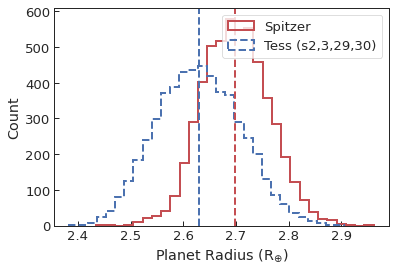

In [41]:
import matplotlib.pyplot as pl
import astropy.units as u

Rs = samples['radius']
Rp_spitzer = np.random.choice(posterior_params_spitzer['b_rr'], len(Rs))*Rs
pl.hist(Rp_spitzer*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='C3', lw=2, label='Spitzer');
pl.axvline(Rp_spitzer.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='C3')

# Rp_tess = np.random.choice(posterior_params_tess['b_rr'], len(Rs))*Rs
# pl.hist(Rp_tess*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='C0', lw=2, label='Tess (s2,3)');
# pl.axvline(Rp_tess.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='C0')
Rp_tess = np.random.choice(posterior_params_tess2['b_rr'], len(Rs))*Rs
pl.hist(Rp_tess*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='C0', lw=2, label='Tess (s2,3,29,30)', ls='--');
pl.axvline(Rp_tess.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='C0')

# Rp_joint = np.random.choice(posterior_params_joint2['b_rr'], len(Rs))*Rs
# pl.hist(Rp_joint*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='k', lw=2, label='Spitzer+Tess (s2,3,29,30)', ls='--');
# pl.axvline(Rp_joint.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='k')


pl.xlabel(r"Planet Radius (R$_{\oplus}$)")
pl.ylabel("Count")
pl.legend()

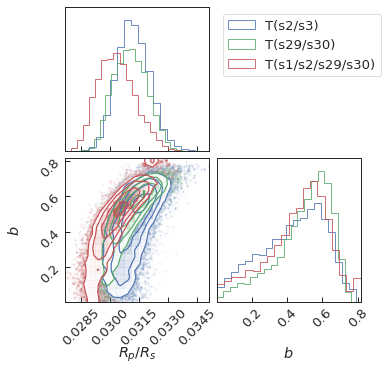

In [42]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

d1 = df['tess']['posterior_samples'][cols]
d2 = df['tess3']['posterior_samples'][cols]
d3 = df['tess2']['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d3, color="C2", weights=np.ones(len(d3))/len(d3), fig=fig);
fig3 = corner.corner(d2, color="C3", 
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig, weights=np.ones(len(d2))/len(d2))
fig.axes[0].legend(["T(s2/s3)",
                    "T(s29/s30)",
                    "T(s1/s2/s29/s30)"],
                    bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )

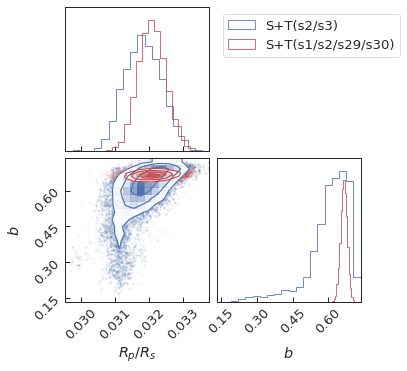

In [60]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

d1 = df['joint']['posterior_samples'][cols]
# d2 = df['joint3']['posterior_samples'][cols]
d3 = df['joint2']['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
# fig2 = corner.corner(d3, color="C2", weights=np.ones(len(d3))/len(d3), fig=fig);
fig3 = corner.corner(d2, color="C3", 
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig, weights=np.ones(len(d2))/len(d2))
fig.axes[0].legend(["S+T(s2/s3)",
#                     "T(s29/s30)",
                    "S+T(s1/s2/s29/s30)"
                   ],
                    bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )

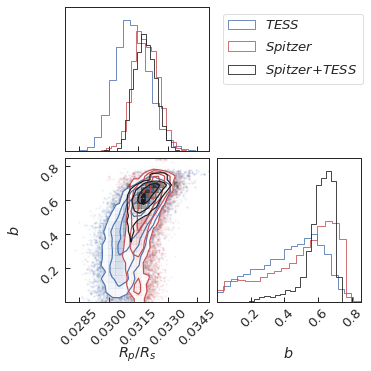

In [76]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

d1 = df['tess']['posterior_samples'][cols]
d2 = df['spitzer']['posterior_samples'][cols]
d3 = df['joint']['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3", fig=fig, weights=np.ones(len(d2))/len(d2));
fig3 = corner.corner(d3, color="k", 
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig2, weights=np.ones(len(d3))/len(d3))
fig.axes[0].legend(["$TESS$",
                    "$Spitzer$",
                    "$Spitzer$+$TESS$"
                   ], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )

In [74]:
fig3.savefig('../figures/transit_corner_comparison.png', bbox_inches='tight')

Text(0.5, 0.98, 'without rhostar prior')

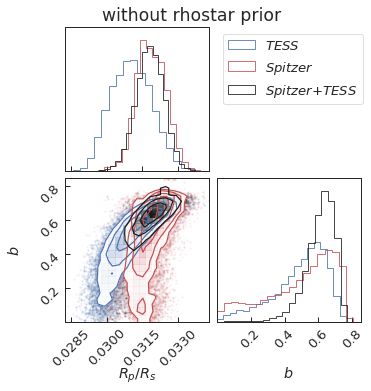

In [77]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

d1 = df['tess2']['posterior_samples'][cols]
d2 = df['spitzer']['posterior_samples'][cols]
d3 = df['joint2']['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3", fig=fig, weights=np.ones(len(d2))/len(d2));
fig3 = corner.corner(d3, color="k", 
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig2, weights=np.ones(len(d3))/len(d3))
fig.axes[0].legend(["$TESS$",
                    "$Spitzer$",
                    "$Spitzer$+$TESS$"
                   ], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )
fig.suptitle("without rhostar prior")

## with rhostar prior

In [78]:
import flammkuchen as fk

df2 = {}
df2 = fk.load("../allesfitter/transit/with_rhostar_prior/spitzer/spitzer_results.h5")
df2['spitzer'].keys()

dict_keys(['baseline', 'detrended_flux', 'flux', 'flux_err', 'model', 'posterior_samples', 'residuals', 'time'])

In [79]:
d = fk.load("../allesfitter/transit/with_rhostar_prior/tess2/tess2_results.h5")
df2['tess2'] = d['tess']
df2['tess2'].keys()

dict_keys(['baseline', 'detrended_flux', 'flux', 'flux_err', 'model', 'posterior_samples', 'residuals', 'time'])

In [80]:
d = fk.load("../allesfitter/transit/with_rhostar_prior/tess_spitzer2/tess_spitzer2_results.h5")
df2['joint2'] = d
df2['joint2'].keys()

dict_keys(['baseline_spitzer', 'baseline_tess', 'detrended_flux_spitzer', 'detrended_flux_tess', 'model_spitzer', 'model_tess', 'posterior_samples', 'residuals_spitzer', 'residuals_tess'])

Text(0.5, 0.98, 'with rhostar prior')

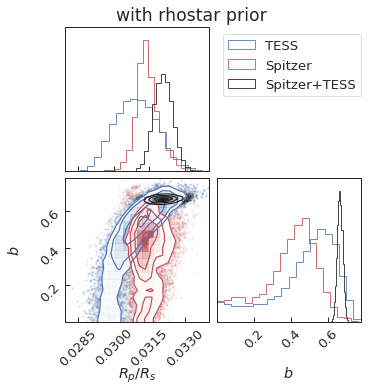

In [81]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

d1 = df2['tess2']['posterior_samples'][cols]
d2 = df2['spitzer']['posterior_samples'][cols]
d3 = df2['joint2']['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3", fig=fig, weights=np.ones(len(d2))/len(d2));
fig3 = corner.corner(d3, color="k", 
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig2, weights=np.ones(len(d3))/len(d3))
fig.axes[0].legend(["TESS","Spitzer","Spitzer+TESS"], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )
fig.suptitle("with rhostar prior")

Text(0.5, 0.98, 'tess2')

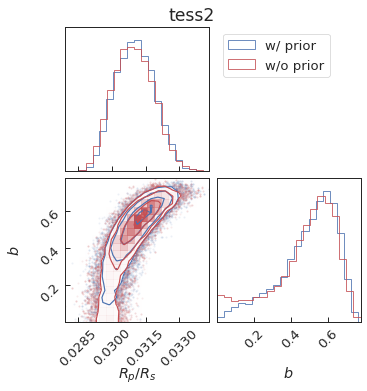

In [66]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

key = 'tess2'
d1 = df[key]['posterior_samples'][cols]
d2 = df2[key]['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3",
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig, weights=np.ones(len(d2))/len(d2))
fig.axes[0].legend(["w/ prior","w/o prior"], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )
fig.suptitle(key)

Text(0.5, 0.98, 'spitzer')

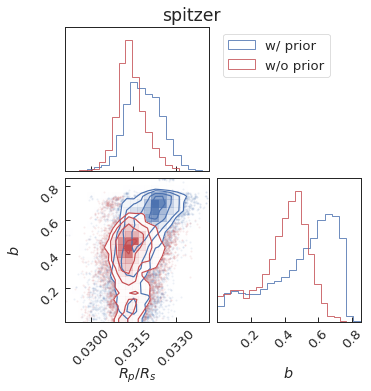

In [67]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

key = 'spitzer'
d1 = df[key]['posterior_samples'][cols]
d2 = df2[key]['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3",
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig, weights=np.ones(len(d2))/len(d2))
fig.axes[0].legend(["w/ prior","w/o prior"], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )
fig.suptitle(key)

Text(0.5, 0.98, 'joint2')

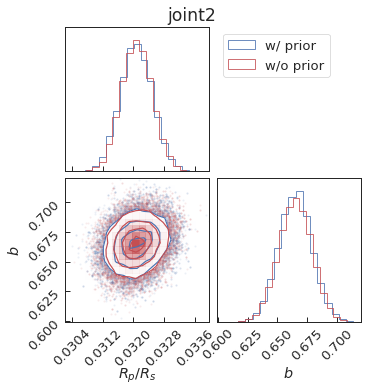

In [68]:
cols = ['b_rr', 'imp_par'] #, 'b_epoch'
names = ['$R_p/R_s$', '$b$'] #r'T$_0$ [BTJD]'

key = 'joint2'
d1 = df[key]['posterior_samples'][cols]
d2 = df2[key]['posterior_samples'][cols]
fig = corner.corner(d1, color="C0", weights=np.ones(len(d1))/len(d1));
fig2 = corner.corner(d2, color="C3",
              labels=names,
               #quantiles=[0.16, 0.5, 0.84],
               #show_titles=True, 
               title_kwargs={"fontsize": 12},
               #title_fmt='.4f',
              fig=fig, weights=np.ones(len(d2))/len(d2))
fig.axes[0].legend(["w/ prior","w/o prior"], 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left'
                  )
fig.suptitle(key)

## save

In [67]:
df.keys()

dict_keys(['tess', 'tess2', 'spitzer', 'joint', 'joint2'])

In [68]:
df['tess'].keys()

dict_keys(['time', 'flux', 'flux_err', 'baseline', 'model', 'detrended_flux', 'residuals', 'posterior_samples'])

In [69]:
df['tess2'].keys()

dict_keys(['time', 'flux', 'flux_err', 'baseline', 'model', 'detrended_flux', 'residuals', 'posterior_samples'])

In [70]:
df['spitzer'].keys()

dict_keys(['time', 'flux', 'flux_err', 'baseline', 'model', 'detrended_flux', 'residuals', 'posterior_samples'])

In [71]:
df['joint'].keys()

dict_keys(['baseline_spitzer', 'model_spitzer', 'detrended_flux_spitzer', 'residuals_spitzer', 'baseline_tess', 'model_tess', 'detrended_flux_tess', 'residuals_tess', 'posterior_samples'])

In [72]:
df['joint2'].keys()

dict_keys(['baseline_spitzer', 'model_spitzer', 'detrended_flux_spitzer', 'residuals_spitzer', 'baseline_tess', 'model_tess', 'detrended_flux_tess', 'residuals_tess', 'posterior_samples'])

In [ ]:
inst = 'spitzer'
pl.plot(df[inst][f'detrended_flux']-df['joint'][f'detrended_flux_{inst}'])

In [68]:
df.keys()

dict_keys(['tess', 'tess2', 'spitzer', 'joint', 'joint2'])

In [74]:
import flammkuchen as dd

dd.save('../data/phot/allesfit_transit_results.h5', df)

In [ ]:
import matplotlib.pyplot as pl
import astropy.units as u
np.random.seed(42)

fig, ax = pl.subplots()
#isochrones samples
Rs = samples['radius']
Rp_spitzer = np.random.choice(posterior_params_spitzer['b_rr'], len(Rs))*Rs
ax.hist(Rp_spitzer*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='C3', lw=2, label='$Spitzer$');
ax.axvline(Rp_spitzer.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='C3')

Rp_tess = np.random.choice(posterior_params_tess['b_rr'], len(Rs))*Rs
ax.hist(Rp_tess*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='C0', lw=2, label='$TESS$');
ax.axvline(Rp_tess.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='C0')

#joint
Rp_joint = np.random.choice(posterior_params_joint2['b_rr'], len(Rs))*Rs
ax.hist(Rp_joint*u.Rsun.to(u.Rearth), bins=30, histtype='step', color='k', lw=2, label='$Spitzer+TESS$');
ax.axvline(Rp_joint.median()*u.Rsun.to(u.Rearth), 0, 1, ls='--', lw=2, color='k')
ax.legend(loc=1, fontsize=12)
ax.set_xlabel(r"Planet radius (R$_{\oplus}$)")
ax.set_ylabel("Posterior Probability Density")
ax.set_yticks([])

In [36]:
fig.savefig('../figures/radii_hist_comp.png', bbox_inches='tight')

## all: space+ground

In [4]:
import os
import pickle
import gzip
from allesfitter import config

datadir = '../allesfitter/transit/all2/'
config.init(datadir)
f = gzip.GzipFile(os.path.join(config.BASEMENT.outdir,'save_ns.pickle.gz'), 'rb')
results = pickle.load(f)
f.close()

results.keys(), len(results)

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458747.64452


(dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale']),
 21)

In [5]:
results['samples'].shape

(45262, 69)

In [6]:
from allesfitter import nested_sampling_output, general_output

posterior_samples = nested_sampling_output.draw_ns_posterior_samples(results)
posterior_samples.shape

(45262, 69)

In [7]:
config.BASEMENT.fitkeys, len(config.BASEMENT.fitkeys) 

(array(['b_rr', 'b_rsuma', 'b_cosi', 'b_epoch', 'b_period', 'dil_tess',
        'dil_spitzer', 'dil_lco_ip', 'dil_lco_up', 'dil_lco_gp',
        'dil_lco_B', 'dil_lco_zs', 'dil_pest_Ic', 'dil_mko_ip',
        'dil_ngts_r', 'dil_kelt_r', 'host_ldc_q1_lco_ip',
        'host_ldc_q2_lco_ip', 'host_ldc_q1_lco_up', 'host_ldc_q2_lco_up',
        'host_ldc_q1_lco_gp', 'host_ldc_q2_lco_gp', 'host_ldc_q1_lco_B',
        'host_ldc_q2_lco_B', 'host_ldc_q1_lco_zs', 'host_ldc_q2_lco_zs',
        'host_ldc_q1_pest_Ic', 'host_ldc_q2_pest_Ic', 'host_ldc_q1_ngts_r',
        'host_ldc_q2_ngts_r', 'host_ldc_q1_kelt_r', 'host_ldc_q2_kelt_r',
        'host_ldc_q1_mko_ip', 'host_ldc_q2_mko_ip', 'host_ldc_q1_kelt_r',
        'host_ldc_q2_kelt_r', 'ln_err_flux_tess', 'ln_err_flux_spitzer',
        'ln_err_flux_lco_ip', 'ln_err_flux_lco_up', 'ln_err_flux_lco_gp',
        'ln_err_flux_lco_B', 'ln_err_flux_lco_zs', 'ln_err_flux_ngts_r',
        'ln_err_flux_pest_Ic', 'ln_err_flux_mko_ip', 'ln_err_flux_kelt_r',
  

In [8]:
posterior_params = nested_sampling_output.draw_ns_posterior_samples(results, as_type='dic') # all weighted posterior_samples
posterior_params_median, posterior_params_ll, posterior_params_ul = general_output.get_params_from_samples(posterior_samples)

In [9]:
import allesfitter
import numpy as np

af = allesfitter.allesclass(datadir)

Filling the Basement

Filling the Basement


allesfitter version
---------------------
v1.2.8

Shifting epochs into the data center
------------------------------------
Companion b
	input epoch: 2458747.64452


In [10]:
instruments = list(config.BASEMENT.fulldata.keys())
instruments

['tess', 'spitzer', 'lco_up', 'lco_gp', 'lco_B', 'lco_zs']

In [11]:
# inst_names = ['$TESS$', '$Spitzer$', 'LCO u\'', 'LCO i\'', 'LCO g\'', 'NGTS', 'KELT']
inst_names = ['$TESS$', '$Spitzer$', 'LCO u\'', 'LCO g\'', 'LCO B', 'LCO $z_s$']

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'lco_up, companion b'}, xlabel='$\\mathrm{ T - T_0 \\ (h) }$', ylabel='Relative Flux - Baseline'>)

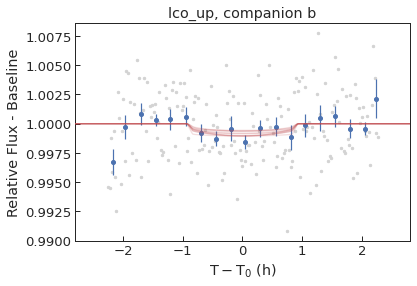

In [12]:
#'full' / 'phase' / 'phasezoom'
i = 'lco_up'
af.plot(i, 'b', style='phasezoom')

Text(0.5, 0.05, 'Mid-transit (Hours)')

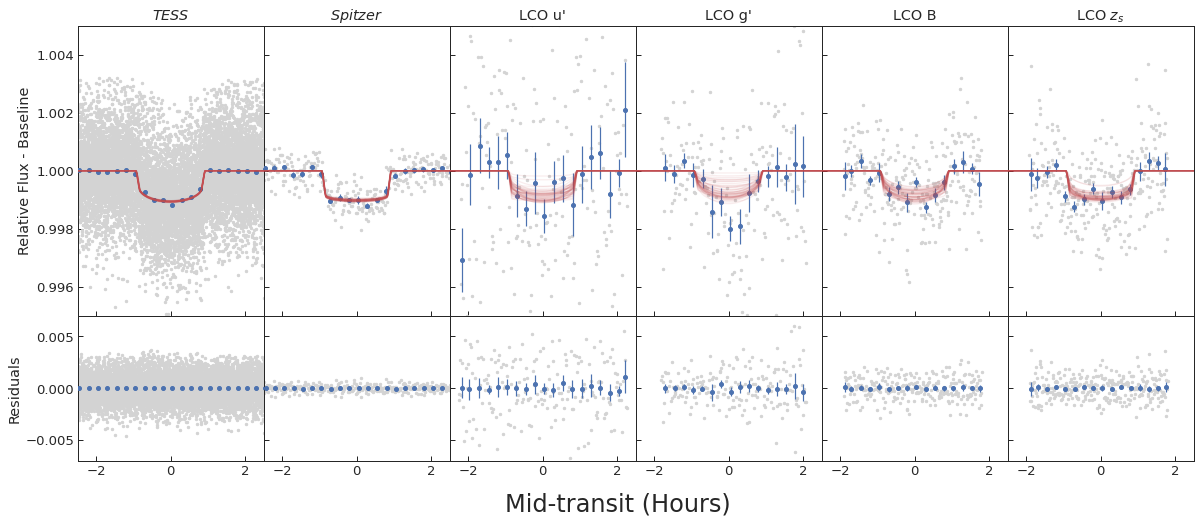

In [13]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.995,1.005]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=50
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', mode='initial_guess', force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

Text(0.5, 0.05, 'Mid-transit (Hours)')

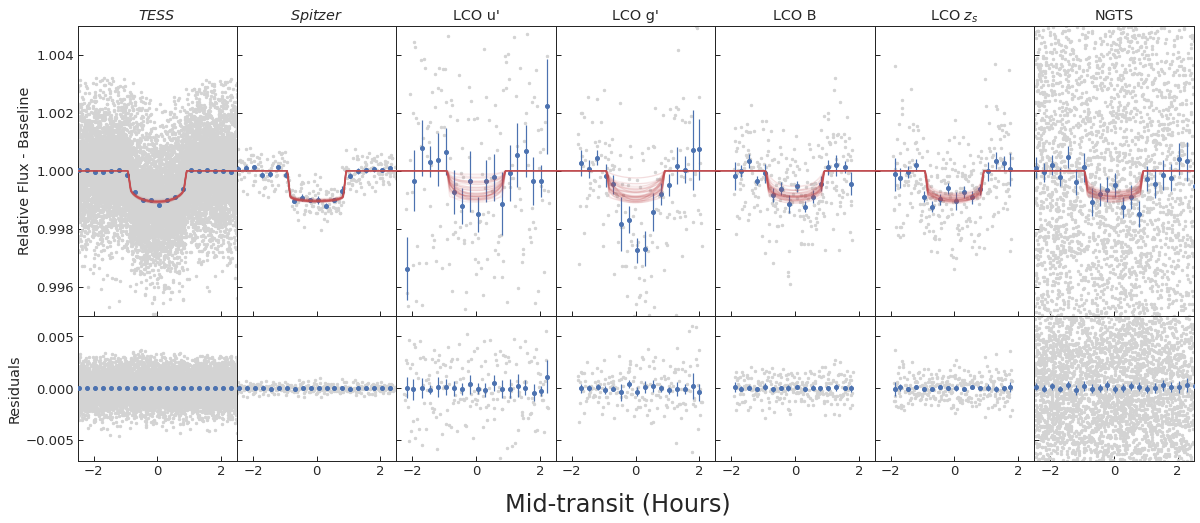

In [15]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.995,1.005]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=50
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', mode='initial_guess', force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

Text(0.5, 0.05, 'Mid-transit (Hours)')

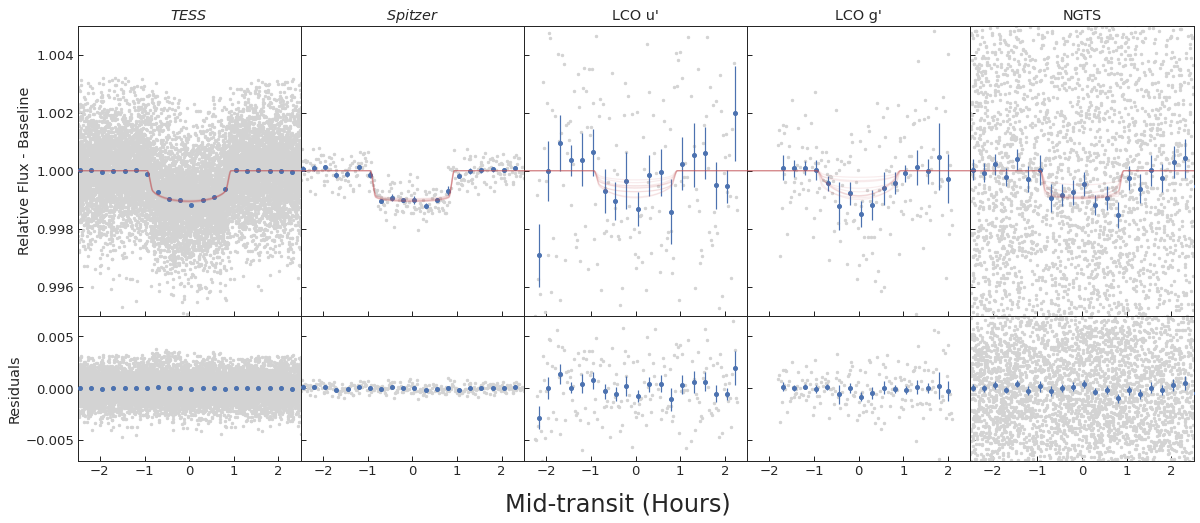

In [16]:
import matplotlib.pyplot as plt

ninst = len(instruments)
fig, axes = plt.subplots(2, ninst, 
                         figsize=(20,8), 
                         gridspec_kw={'height_ratios': [2,1]}, 
                         sharey='row', 
                         sharex='col'
                        )
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
ax = axes.flatten()

ylims1 = [0.995,1.005]
ylims2 = [-0.007,0.007]
xlims = [-2.5,2.5]

style = 'phasezoom'
Nsamples=10
for n,inst in enumerate(instruments):
    af.plot(inst, 'b', style, Nsamples=Nsamples, force_binning=True, ax=ax[n])
    af.plot(inst, 'b', f'{style}_residuals', Nsamples=Nsamples, force_binning=True, ax=ax[n+ninst])
    
    ax[n].set_title(inst_names[n])
    ax[n+ninst].set_title('')
    ax[n+ninst].set_xlabel('')
    
    #remove ylabel except first column
    if n!=0:
        ax[n].set_ylabel('')
        ax[n+ninst].set_ylabel('')
        
    ax[n].set_ylim(*ylims1)
    ax[n+ninst].set_ylim(*ylims2)
    
ax[0].set_ylabel('Relative Flux - Baseline')
for axi in ax:
    axi.set_xlim(*xlims)
    
fig.text(0.5, 0.05, 'Mid-transit (Hours)', va='center', ha='center', fontsize=24)

In [16]:
fig.savefig('../figures/lcs_all.png', bbox_inches='tight')

## derived params

In [3]:
import flammkuchen as dd

df = dd.load('../data/phot/allesfit_transit_results.h5')

### vsini

In [44]:
import numpy as np

minerva = pd.read_csv('../data/spec/minerva_rv.txt', delim_whitespace=True, comment='#')
vsini_minerva = minerva.prelimVsini
np.median(vsini_minerva), np.std(vsini_minerva)

(8.266330968467578, 0.029182432807475175)

In [45]:
np.median(samples['radius']), np.percentile(samples['radius'], [16,84])

(0.7765445281930545, array([0.76750278, 0.78693514]))

In [35]:
import astropy.units as u

Rs = samples['radius']*u.Rsun.to(u.km)
Prot = 4.4*u.day.to(u.second)
inc = np.deg2rad(np.random.choice(df['joint']['posterior_samples']['inc'], len(Rs)))
vsini2 = 2*np.pi*Rs/Prot*np.sin(inc)
np.nanmedian(vsini2), np.nanstd(vsini2)

(8.919112045212618, 0.11256350344665209)

In [47]:
vsini_chiron = np.random.normal(3.41,0.85,size=len(Rs))
P=(2*np.pi*Rs*np.sin(inc))/vsini_minerva#vsini_chiron
np.nanmedian(P*u.second.to(u.day))

4.823044649399611

### Teq

In [51]:
Rs = samples['radius']
Teff = samples['Teff']
aRs = np.random.choice(df_samples['aRs'], len(Rs))
Teq_samples = (Teff * np.sqrt(Rs / (2 * aRs)))
Teq_samples.median(), Teq_samples.std()

(894.7508435020263, 35.561223309650245)

In [16]:
np.median(af.posterior_params['host_ldc_q1_tess']), np.std(af.posterior_params['host_ldc_q2_tess'] )

(0.3059200799974964, 0.3864129038122437)

In [17]:
np.median(af.posterior_params['host_ldc_q1_spitzer']), np.std(af.posterior_params['host_ldc_q2_spitzer'] )

(-1.0281288889461961, 0.8584369661127428)

## custom plots

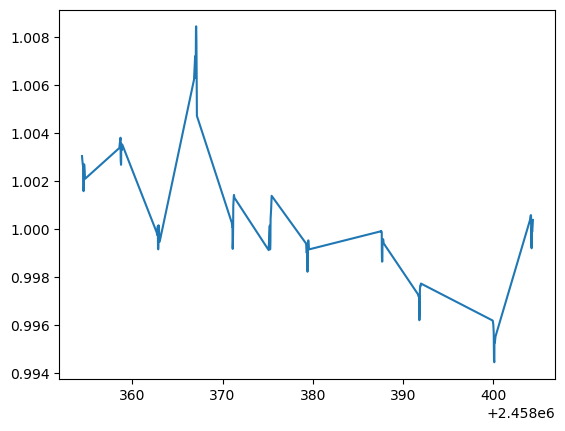

In [41]:
inst = 'tess'
t = af.data[inst]['time']
f = af.data[inst]['flux']
# pl.plot(t,f)
b = af.get_posterior_median_baseline(inst, 'flux')
m = af.get_posterior_median_model(inst, 'flux')
pl.plot(t,m+b)

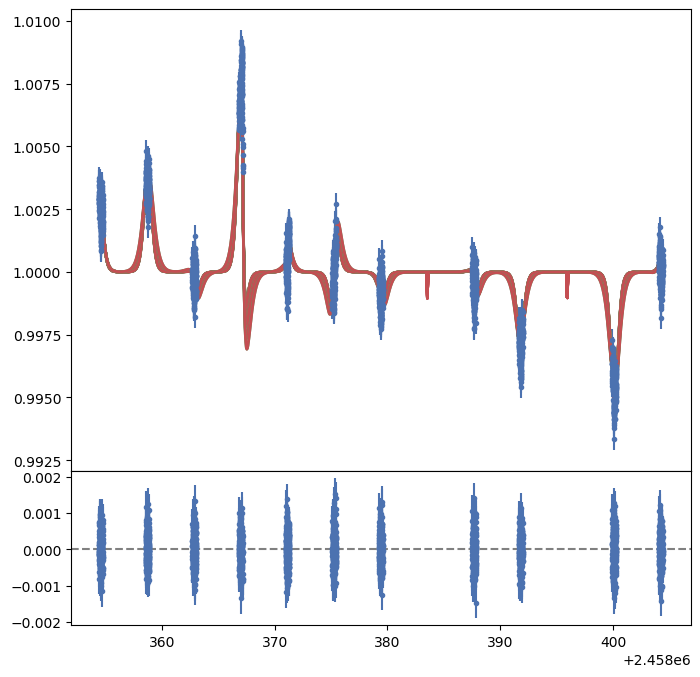

In [42]:
#::: settings
inst = 'tess'
key = 'flux'

#::: load the time, flux, and flux_err
time = af.data[inst]['time']
flux = af.data[inst][key]
flux_err = af.data[inst]['err_scales_'+key] * af.posterior_params_median['err_'+key+'_'+inst]

#::: set up the figure
fig, axes = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

#::: top panel: plot the data and 20 curves from random posterior samples (evaluated on a fine time grid)
ax = axes[0]
ax.errorbar(time, flux, flux_err, fmt='b.')
for i in range(20):
    time_fine = np.linspace(time[0], time[-1], 1000)
    model_fine, baseline_fine, _ = af.get_one_posterior_curve_set(inst, key, xx=time_fine)
    ax.plot(time_fine, 1.+baseline_fine, 'g-', lw=2)
    ax.plot(time_fine, model_fine+baseline_fine, 'r-', lw=2)

#::: bottom panel: plot the residuals;
#::: for that, subtract the "posterior median model" and "posterior median baseline" from the data (evaluated on the time stamps of the data)
ax = axes[1]
baseline = af.get_posterior_median_baseline(inst, key)
model = af.get_posterior_median_model(inst, key)
ax.errorbar(time, flux-(model+baseline), flux_err, fmt='b.')
ax.axhline(0, color='grey', linestyle='--')

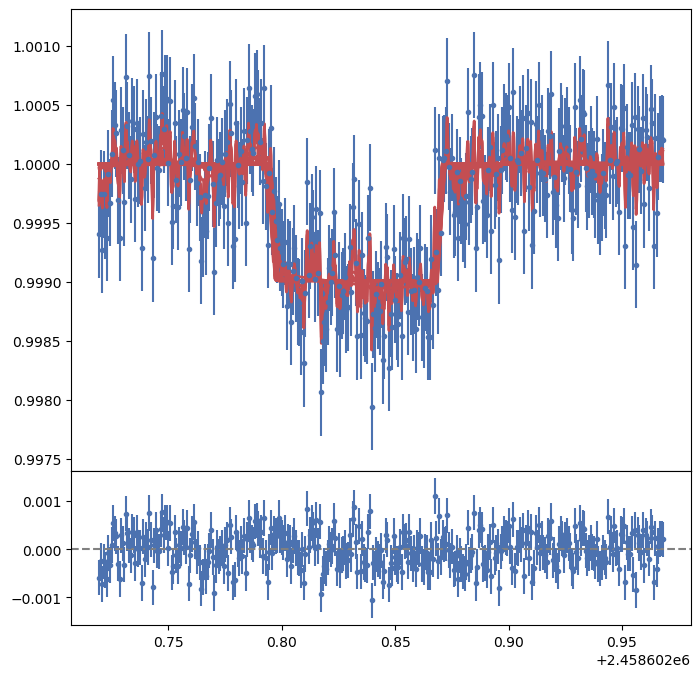

In [44]:
#::: settings
inst = 'spitzer'
key = 'flux'

#::: load the time, flux, and flux_err
time = af.data[inst]['time']
flux = af.data[inst][key]
flux_err = af.data[inst]['err_scales_'+key] * af.posterior_params_median['err_'+key+'_'+inst]

#::: set up the figure
fig, axes = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

#::: top panel: plot the data and 20 curves from random posterior samples (evaluated on a fine time grid)
ax = axes[0]
ax.errorbar(time, flux, flux_err, fmt='b.')
for i in range(20):
    time_fine = np.linspace(time[0], time[-1], 1000)
    model_fine, baseline_fine, _ = af.get_one_posterior_curve_set(inst, key, xx=time_fine)
    #ax.plot(time_fine, 1.+baseline_fine, 'g-', lw=2)
    ax.plot(time_fine, model_fine+baseline_fine, 'r-', lw=2)

#::: bottom panel: plot the residuals;
#::: for that, subtract the "posterior median model" and "posterior median baseline" from the data (evaluated on the time stamps of the data)
ax = axes[1]
baseline = af.get_posterior_median_baseline(inst, key)
model = af.get_posterior_median_model(inst, key)
ax.errorbar(time, flux-(model+baseline), flux_err, fmt='b.')
ax.axhline(0, color='grey', linestyle='--')

## API
https://www.allesfitter.com/api